In [ ]:
! pip install -U albumentations

In [ ]:
! pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 22.9 MB/s 


In [ ]:
import os
import torch
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import albumentations as A
import torch.optim as optim
from google.colab import drive
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
class GalaxyDataset(Dataset):
    def __init__(self, img_dir, mask_dir, images, masks, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        img_path = os.path.join(self.img_dir, self.images[item])
        mask_path = os.path.join(self.mask_dir, self.images[item])
        # print(img_path, mask_path)
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'), dtype='float32')
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        return image, mask

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature,
                                               kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

In [ ]:
LEARNING_RATE = 8e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 64  # 1280 originally
IMAGE_WIDTH = 64  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
PATH = 'drive/MyDrive/ACT'
TRAIN_IMG_DIR = "dataset64"
TRAIN_MASK_DIR = "mask64"
VAL_IMG_DIR = "dataset64"
VAL_MASK_DIR = "mask64"

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0]
        ),
        ToTensorV2()
    ]
)

In [ ]:
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0]
        ),
        ToTensorV2()
    ]
)

In [ ]:
from sklearn.model_selection import train_test_split
X = os.listdir(os.path.join(PATH, TRAIN_IMG_DIR))
y = os.listdir(os.path.join(PATH, TRAIN_MASK_DIR))
X_train, X_test, y_train, y_test = train_test_split(sorted(X), sorted(y), test_size=0.1, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))
# X_test[:10], y_test[:10]

1713 191 1713 191


In [ ]:
train_ds = GalaxyDataset(img_dir=os.path.join(PATH, TRAIN_IMG_DIR), 
                         mask_dir=os.path.join(PATH, TRAIN_MASK_DIR),
                         images=X_train,
                         masks=y_train,
                         transform=train_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = GalaxyDataset(
    img_dir=os.path.join(PATH, VAL_IMG_DIR), 
    mask_dir=os.path.join(PATH, VAL_MASK_DIR),
    images=X_test,
    masks=y_test,
    transform=val_transform,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
a = iter(train_loader)
data, label = a.next()
label.shape

In [ ]:
def check_accuracy(loader, model, acc, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    # )
    print(f"Dice score: {dice_score/len(loader)}")
    acc.append(dice_score/len(loader))
    model.train()

In [ ]:
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = model(x)
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/{idx}.png")
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
    model.train()

In [ ]:
def save_checkpoint(state, filename=os.path.join(PATH, "my_checkpoint.pth.tar")):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [ ]:
if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

In [ ]:
def test(model, loader, loss_fn, optimizer, losses):
    running_loss = 0
    # loop = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for data, mask in loader:
            data = data.to(device=DEVICE)
            mask = mask.float().unsqueeze(1).to(device=DEVICE)
            outputs = model(data)
            loss = loss_fn(outputs, mask)
            running_loss += loss * loader.batch_size
            # loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader.dataset)
    losses.append(epoch_loss)
    print('AVG Test Loss: {:.4f}'.format(epoch_loss))

In [ ]:
def train(model, train_dl, loss_fn, optimizer, losses):
    train_loss, valid_loss = [], []
    step = 0
    running_loss = 0.0
    running_acc = 0.0
    loop = tqdm(train_dl)
    for data, mask in loop:
        data = data.to(device=DEVICE)
        mask = mask.float().unsqueeze(1).to(device=DEVICE)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, mask)
        loss.backward()
        optimizer.step()
        running_loss += loss * train_dl.batch_size
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dl.dataset)
    losses.append(epoch_loss.item())
    print('AVG Training Loss: {:.4f}'.format(epoch_loss))

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
model.train()
loss_fn = nn.BCEWithLogitsLoss()
optimazer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses = []
test_losses = []
acc = []
for epoch in range(NUM_EPOCHS):
    print("starting {} epoch...".format(epoch))
    train(model, train_loader, loss_fn, optimazer, train_losses)
    test(model, val_loader, loss_fn, optimazer, test_losses)
    torch.cuda.empty_cache()
    check_accuracy(val_loader, model, acc, device=DEVICE)
    save_predictions_as_imgs(val_loader, model, 
                             folder=os.path.join(PATH, 'saved'), 
                             device=DEVICE)

starting 0 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.379]

Loss: 0.4451


AVG Test Loss: 0.4342
Dice score: 0.048008184880018234
starting 1 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.354]

Loss: 0.3103


AVG Test Loss: 0.3511
Dice score: 0.4947817027568817
starting 2 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.261]

Loss: 0.2562


AVG Test Loss: 0.2395
Dice score: 0.6507317423820496
starting 3 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.24]

Loss: 0.2178


AVG Test Loss: 0.2013
Dice score: 0.691642701625824
starting 4 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.211]

Loss: 0.1885


AVG Test Loss: 0.1782
Dice score: 0.7025986909866333
starting 5 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.198]

Loss: 0.1638


AVG Test Loss: 0.1492
Dice score: 0.7229593992233276
starting 6 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.156]

Loss: 0.1440


AVG Test Loss: 0.1358
Dice score: 0.7004469633102417
starting 7 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.127]

Loss: 0.1266


AVG Test Loss: 0.1192
Dice score: 0.716171145439148
starting 8 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.134]

Loss: 0.1125


AVG Test Loss: 0.1033
Dice score: 0.7370582818984985
starting 9 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.107]

Loss: 0.0997


AVG Test Loss: 0.0948
Dice score: 0.7574684023857117
starting 10 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.085]

Loss: 0.0896


AVG Test Loss: 0.0830
Dice score: 0.7495285868644714
starting 11 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0755]

Loss: 0.0803


AVG Test Loss: 0.0732
Dice score: 0.7715729475021362
starting 12 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0683]

Loss: 0.0726


AVG Test Loss: 0.0679
Dice score: 0.7604728937149048
starting 13 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.0766]

Loss: 0.0665


AVG Test Loss: 0.0606
Dice score: 0.7368513941764832
starting 14 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0567]

Loss: 0.0605


AVG Test Loss: 0.0562
Dice score: 0.761643648147583
starting 15 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0635]

Loss: 0.0556


AVG Test Loss: 0.0522
Dice score: 0.7616770267486572
starting 16 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0523]

Loss: 0.0511


AVG Test Loss: 0.0465
Dice score: 0.7784950733184814
starting 17 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.09it/s, loss=0.046]

Loss: 0.0469


AVG Test Loss: 0.0436
Dice score: 0.7673176527023315
starting 18 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0416]

Loss: 0.0437


AVG Test Loss: 0.0393
Dice score: 0.7818471789360046
starting 19 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0664]

Loss: 0.0411


AVG Test Loss: 0.0368
Dice score: 0.7792791724205017
starting 20 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0418]

Loss: 0.0384


AVG Test Loss: 0.0370
Dice score: 0.778731107711792
starting 21 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0338]

Loss: 0.0358


AVG Test Loss: 0.0310
Dice score: 0.8105062246322632
starting 22 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0313]

Loss: 0.0335


AVG Test Loss: 0.0305
Dice score: 0.7986254096031189
starting 23 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.035]

Loss: 0.0316


AVG Test Loss: 0.0291
Dice score: 0.8075942993164062
starting 24 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0386]

Loss: 0.0303


AVG Test Loss: 0.0276
Dice score: 0.7801620960235596
starting 25 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0341]

Loss: 0.0285


AVG Test Loss: 0.0253
Dice score: 0.7995328903198242
starting 26 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.09it/s, loss=0.0214]

Loss: 0.0267


AVG Test Loss: 0.0234
Dice score: 0.8218921422958374
starting 27 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0232]

Loss: 0.0252


AVG Test Loss: 0.0220
Dice score: 0.8099905848503113
starting 28 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0194]

Loss: 0.0243


AVG Test Loss: 0.0226
Dice score: 0.7417227029800415
starting 29 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0343]

Loss: 0.0235


AVG Test Loss: 0.0207
Dice score: 0.786724328994751
starting 30 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.0269]

Loss: 0.0227


AVG Test Loss: 0.0213
Dice score: 0.8120178580284119
starting 31 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0214]

Loss: 0.0218


AVG Test Loss: 0.0184
Dice score: 0.8143967986106873
starting 32 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0197]

Loss: 0.0207


AVG Test Loss: 0.0173
Dice score: 0.8237637281417847
starting 33 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.025]

Loss: 0.0201


AVG Test Loss: 0.0185
Dice score: 0.807026743888855
starting 34 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.017]

Loss: 0.0192


AVG Test Loss: 0.0166
Dice score: 0.8167061805725098
starting 35 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0139]

Loss: 0.0184


AVG Test Loss: 0.0161
Dice score: 0.8103055953979492
starting 36 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0209]

Loss: 0.0185


AVG Test Loss: 0.0149
Dice score: 0.8233400583267212
starting 37 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0202]

Loss: 0.0182


AVG Test Loss: 0.0147
Dice score: 0.810714602470398
starting 38 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.0188]

Loss: 0.0171


AVG Test Loss: 0.0150
Dice score: 0.815780758857727
starting 39 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0183]

Loss: 0.0168


AVG Test Loss: 0.0136
Dice score: 0.8195433020591736
starting 40 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.013]

Loss: 0.0163


AVG Test Loss: 0.0138
Dice score: 0.8245668411254883
starting 41 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.07it/s, loss=0.0244]

Loss: 0.0160


AVG Test Loss: 0.0135
Dice score: 0.8180719614028931
starting 42 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0184]

Loss: 0.0162


AVG Test Loss: 0.0126
Dice score: 0.8282376527786255
starting 43 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0211]

Loss: 0.0156


AVG Test Loss: 0.0124
Dice score: 0.8209211826324463
starting 44 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0147]

Loss: 0.0150


AVG Test Loss: 0.0125
Dice score: 0.826047420501709
starting 45 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.033]

Loss: 0.0151


AVG Test Loss: 0.0129
Dice score: 0.8219846487045288
starting 46 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0121]

Loss: 0.0155


AVG Test Loss: 0.0124
Dice score: 0.8190500736236572
starting 47 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.0224]

Loss: 0.0145


AVG Test Loss: 0.0113
Dice score: 0.8342839479446411
starting 48 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0164]

Loss: 0.0138


AVG Test Loss: 0.0118
Dice score: 0.8151301145553589
starting 49 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0237]

Loss: 0.0139


AVG Test Loss: 0.0115
Dice score: 0.8376752734184265
starting 50 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.0103]

Loss: 0.0136


AVG Test Loss: 0.0107
Dice score: 0.8255833387374878
starting 51 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0197]

Loss: 0.0133


AVG Test Loss: 0.0115
Dice score: 0.8101469874382019
starting 52 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0141]

Loss: 0.0133


AVG Test Loss: 0.0105
Dice score: 0.8391643762588501
starting 53 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00643]

Loss: 0.0132


AVG Test Loss: 0.0104
Dice score: 0.8313041925430298
starting 54 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.019]

Loss: 0.0129


AVG Test Loss: 0.0104
Dice score: 0.8234274387359619
starting 55 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0215]

Loss: 0.0124


AVG Test Loss: 0.0102
Dice score: 0.828079879283905
starting 56 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00703]

Loss: 0.0123


AVG Test Loss: 0.0102
Dice score: 0.8275457620620728
starting 57 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0112]

Loss: 0.0120


AVG Test Loss: 0.0097
Dice score: 0.8411094546318054
starting 58 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0302]

Loss: 0.0126


AVG Test Loss: 0.0107
Dice score: 0.8250555992126465
starting 59 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.07it/s, loss=0.0134]

Loss: 0.0125


AVG Test Loss: 0.0115
Dice score: 0.808064341545105
starting 60 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00719]

Loss: 0.0118


AVG Test Loss: 0.0091
Dice score: 0.8385636806488037
starting 61 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0173]

Loss: 0.0120


AVG Test Loss: 0.0098
Dice score: 0.8290748596191406
starting 62 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.00424]

Loss: 0.0120


AVG Test Loss: 0.0090
Dice score: 0.842862069606781
starting 63 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00814]

Loss: 0.0114


AVG Test Loss: 0.0099
Dice score: 0.8190391063690186
starting 64 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0113]

Loss: 0.0116


AVG Test Loss: 0.0092
Dice score: 0.8346251845359802
starting 65 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00794]

Loss: 0.0112


AVG Test Loss: 0.0092
Dice score: 0.8295608758926392
starting 66 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.007]

Loss: 0.0116


AVG Test Loss: 0.0095
Dice score: 0.820816695690155
starting 67 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00881]

Loss: 0.0109


AVG Test Loss: 0.0097
Dice score: 0.8249169588088989
starting 68 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0117]

Loss: 0.0112


AVG Test Loss: 0.0095
Dice score: 0.8172792792320251
starting 69 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0092]

Loss: 0.0111


AVG Test Loss: 0.0090
Dice score: 0.8266844153404236
starting 70 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00918]

Loss: 0.0110


AVG Test Loss: 0.0092
Dice score: 0.8320295810699463
starting 71 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0111]

Loss: 0.0112


AVG Test Loss: 0.0091
Dice score: 0.813631534576416
starting 72 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00786]

Loss: 0.0108


AVG Test Loss: 0.0089
Dice score: 0.8238054513931274
starting 73 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00733]

Loss: 0.0106


AVG Test Loss: 0.0083
Dice score: 0.8395781517028809
starting 74 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0115]

Loss: 0.0107


AVG Test Loss: 0.0097
Dice score: 0.824751615524292
starting 75 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00836]

Loss: 0.0110


AVG Test Loss: 0.0089
Dice score: 0.8276307582855225
starting 76 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0101]

Loss: 0.0109


AVG Test Loss: 0.0086
Dice score: 0.8331822752952576
starting 77 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00968]

Loss: 0.0112


AVG Test Loss: 0.0088
Dice score: 0.8229901790618896
starting 78 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.10it/s, loss=0.011]

Loss: 0.0105


AVG Test Loss: 0.0083
Dice score: 0.8369919657707214
starting 79 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00181]

Loss: 0.0106


AVG Test Loss: 0.0092
Dice score: 0.8217034339904785
starting 80 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0167]

Loss: 0.0107


AVG Test Loss: 0.0082
Dice score: 0.8369171023368835
starting 81 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00773]

Loss: 0.0104


AVG Test Loss: 0.0084
Dice score: 0.8293056488037109
starting 82 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00764]

Loss: 0.0104


AVG Test Loss: 0.0091
Dice score: 0.8306576609611511
starting 83 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0258]

Loss: 0.0107


AVG Test Loss: 0.0083
Dice score: 0.8418469429016113
starting 84 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.011]

Loss: 0.0112


AVG Test Loss: 0.0084
Dice score: 0.8417613506317139
starting 85 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00703]

Loss: 0.0107


AVG Test Loss: 0.0077
Dice score: 0.8435438871383667
starting 86 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.00927]

Loss: 0.0105


AVG Test Loss: 0.0083
Dice score: 0.8374559283256531
starting 87 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00714]

Loss: 0.0105


AVG Test Loss: 0.0084
Dice score: 0.8287164568901062
starting 88 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00465]

Loss: 0.0103


AVG Test Loss: 0.0079
Dice score: 0.840999960899353
starting 89 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0069]

Loss: 0.0101


AVG Test Loss: 0.0083
Dice score: 0.8423937559127808
starting 90 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0253]

Loss: 0.0102


AVG Test Loss: 0.0081
Dice score: 0.8258124589920044
starting 91 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.019]

Loss: 0.0112


AVG Test Loss: 0.0081
Dice score: 0.8384575247764587
starting 92 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.022]

Loss: 0.0104


AVG Test Loss: 0.0091
Dice score: 0.8163702487945557
starting 93 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0227]

Loss: 0.0105


AVG Test Loss: 0.0093
Dice score: 0.8088045120239258
starting 94 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0224]

Loss: 0.0110


AVG Test Loss: 0.0075
Dice score: 0.8480185270309448
starting 95 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00528]

Loss: 0.0104


AVG Test Loss: 0.0074
Dice score: 0.8526100516319275
starting 96 epoch...


100%|██████████| 108/108 [00:34<00:00,  3.09it/s, loss=0.0075]

Loss: 0.0103


AVG Test Loss: 0.0081
Dice score: 0.8399009108543396
starting 97 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.00701]

Loss: 0.0102


AVG Test Loss: 0.0078
Dice score: 0.8362473845481873
starting 98 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.011]

Loss: 0.0099


AVG Test Loss: 0.0081
Dice score: 0.823898434638977
starting 99 epoch...


100%|██████████| 108/108 [00:35<00:00,  3.08it/s, loss=0.0155]

Loss: 0.0103


AVG Test Loss: 0.0077
Dice score: 0.8290505409240723


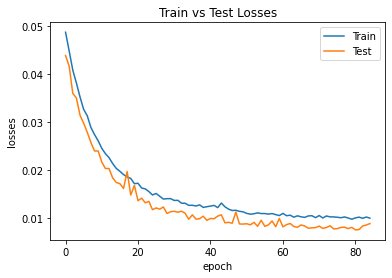

In [ ]:
plt.plot(train_losses[15:])
plt.plot(test_losses[15:])
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
plt.savefig(os.path.join(PATH,
                "loss_{}_epoch_{}_size.png".format(NUM_EPOCHS, IMAGE_HEIGHT)))
plt.show()

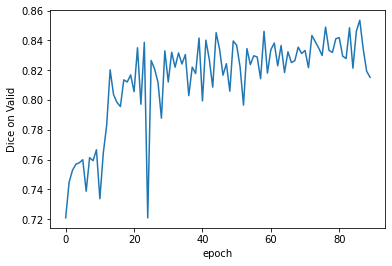

In [ ]:
plt.plot(acc[10:])
plt.xlabel('epoch')
plt.ylabel('Dice on Valid')
plt.savefig(os.path.join(PATH,
                "dice_{}_epoch_{}_size.png".format(NUM_EPOCHS, IMAGE_HEIGHT)))
plt.show()